# Computer vision part 1

- тонкости препроцессинга (читать, ресайзить, вот это вот все)
- CAM (class activation map) из предобученной сетки

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import json

from tqdm.auto import tqdm

# Применяем сетку к картинке

- Тут будет про eval/train-режимы
- Про чтение картинки руками (порядок цветов и нормализацию)

In [2]:
net = torchvision.models.resnet50(pretrained=True)

In [3]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
def load(path):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    img = cv2.imread(path)
    img = cv2.resize(img, (320, 210))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = (img - mean) / std
    img = img.transpose([2, 0, 1]).astype(np.float32)
    return img
    
doge = load('./doge.jpeg')

In [39]:
doge.shape

(3, 210, 320)

In [40]:
net.eval()
out = net(torch.tensor(doge[None, ...])).detach().numpy()

In [41]:
out.argmax(-1)

array([253])

In [7]:
with open("imagenet_1k.json") as fin:
    clsidx = json.load(fin)

# Здесь делаем CAM из готовой сетки

1. Руками с помощью хука
2. Модифицируя сетку

In [46]:
net = torchvision.models.resnet50(pretrained=True)
tosee = []
def cam_hook(module, inp, out):
    tosee.append(inp[0].detach())

net._modules.get("avgpool").register_forward_hook(cam_hook)
net.eval()
out = net(torch.tensor(doge[None, ...])).detach().numpy()


In [47]:
x = tosee[0]
x = x.permute([0, 2, 3, 1])
out = net._modules.get('fc')(x).detach().numpy()

In [48]:
z = net._modules.get('fc').weight.data.numpy()

In [49]:
tt = out[0, ..., 151]

In [50]:
tt

array([[ 0.13142629,  0.36048272,  0.32437626,  2.1582422 ,  2.887826  ,
         2.493912  ,  2.7310944 ,  0.990312  ,  0.6727354 , -0.02236767],
       [-0.28112987, -0.57812834, -0.36107674,  3.0839622 ,  4.056895  ,
         7.0350165 ,  6.8728256 ,  6.65835   ,  0.21011402,  0.17449264],
       [-0.10432386, -0.30154288, -0.84236515,  6.322705  ,  9.122297  ,
        12.754113  , 13.848098  , 10.521458  ,  0.24951795, -0.47986734],
       [-0.14799598, -0.94147676, -0.716554  ,  9.851541  , 12.284594  ,
        15.494075  , 14.921496  , 12.972054  ,  2.3440645 , -1.0494906 ],
       [-0.20696591, -0.8135688 , -1.0107672 , 14.036806  , 20.514008  ,
        18.906248  , 16.554539  , 12.286147  ,  3.6878583 , -0.11451112],
       [ 0.5670946 , -0.26367405, -0.95304424, 12.167611  , 17.86809   ,
        18.790024  , 14.712947  , 12.140746  ,  3.0260878 ,  1.2708104 ],
       [ 0.92471135,  0.1880635 , -0.6634257 ,  6.404029  , 11.639331  ,
        14.547642  , 10.232444  ,  8.143112  

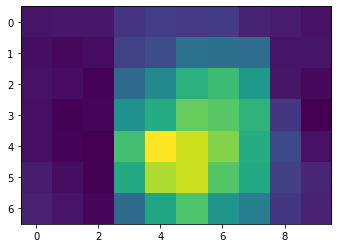

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(tt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


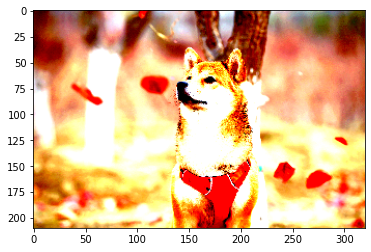

In [52]:
plt.imshow(doge.transpose(1, 2, 0))